# A3 report: Weakest link classification

Team members: Reem, Rasa, Amol, Kalle

---

## 1. Problem statement

The goal is to classify the weakest link in a squat movement. Given 38 movement features, the model predicts which body region is limiting the person's squat. The input is 38 movement features and the output is a body region classification which is upper and lower body. Due to massive class imbalance in the original 14 class problem with some classes with only 1-2 datapoints, we changed to a 2-class approach that gives predictions that actually helps.

### Original 14 weak link classes 

| Body region | Original classes |
|-------------|------------------|
| Upper Body | ForwardHead, LeftArmFallForward, RightArmFallForward, LeftShoulderElevation, RightShoulderElevation |
| Lower Body | ExcessiveForwardLean, LeftAsymmetricalWeightShift, RightAsymmetricalWeightShift, LeftKneeMovesInward, RightKneeMovesInward, LeftKneeMovesOutward, RightKneeMovesOutward, LeftHeelRises, RightHeelRises |

## 2. Data preparation

The classification dataset is created by merging two files from Datasets_all/. The scores_and_weaklink.csv contains 14 weak link scores per movement and aimoscores.csv contains 38 features. The weakest link is found by finding the column with the maximum score using idxmax().

In [121]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import pickle
from sklearn.neighbors import KNeighborsClassifier

In [122]:
# Configuration
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")

# Dataset 1: Weak link scores with 14 categories
weaklink_scores_df = pd.read_csv(os.path.join(DATA_DIR, "scores_and_weaklink.csv"))

# Dataset 2: Movement features (38 features)
movement_features_df = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))

print("Dataset 1 - Weak Link Scores:")
print(f"Shape: {weaklink_scores_df.shape}")
print(f"Columns: {list(weaklink_scores_df.columns)}")

print("\n\nDataset 2 - Movement Features:")
print(f"Shape: {movement_features_df.shape}")
print(f"Columns: {list(movement_features_df.columns)[:10]}...")

Dataset 1 - Weak Link Scores:
Shape: (2096, 17)
Columns: ['ID', 'Date', 'SCORE', 'ForwardHead', 'LeftArmFallForward', 'RightArmFallForward', 'LeftShoulderElevation', 'RightShoulderElevation', 'ExcessiveForwardLean', 'LeftAsymmetricalWeightShift', 'RightAsymmetricalWeightShift', 'LeftKneeMovesInward', 'RightKneeMovesInward', 'LeftKneeMovesOutward', 'RightKneeMovesOutward', 'LeftHeelRises', 'RightHeelRises']


Dataset 2 - Movement Features:
Shape: (2094, 43)
Columns: ['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation']...


## 3. Challenges

The main challenge is the class imbalance where some classes have only 1-2 and some have 400+ samples. We used F1 score as the evaluation metric. Due to this class imbalance, we also tested grouping into 2 body regions of upper and lower body.


Weakest Link Distribution:
WeakestLink
LeftArmFallForward              629
RightArmFallForward             472
RightKneeMovesOutward           278
RightShoulderElevation          250
ForwardHead                     117
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64


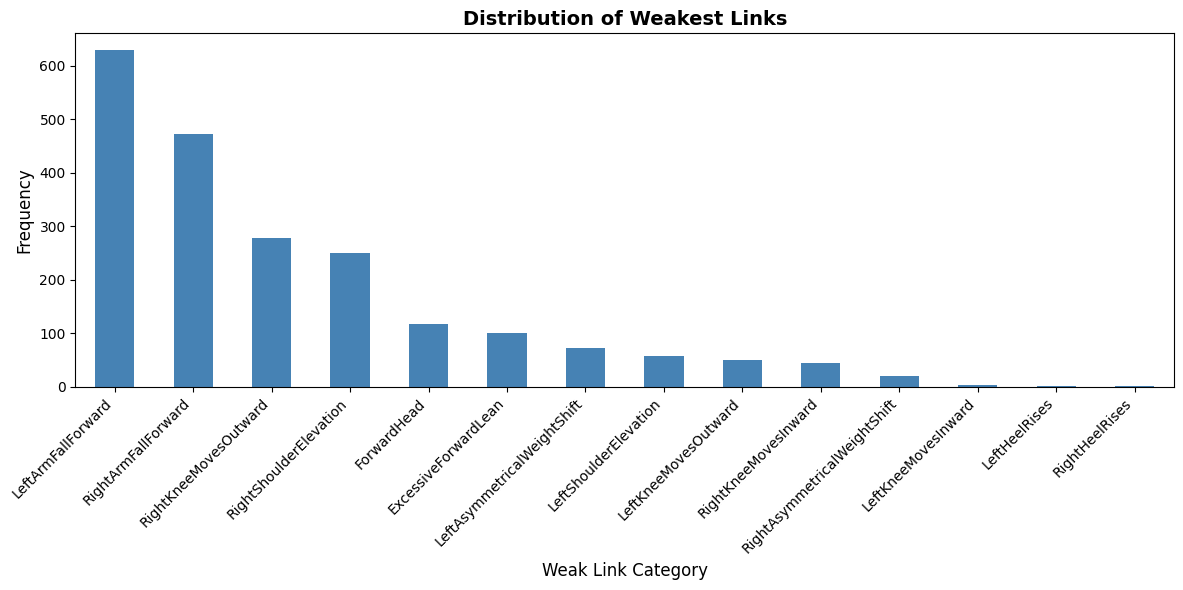

In [123]:
# 14 weak link categories
weaklink_categories = [
    "ForwardHead",
    "LeftArmFallForward", "RightArmFallForward",
    "LeftShoulderElevation", "RightShoulderElevation",
    "ExcessiveForwardLean",
    "LeftAsymmetricalWeightShift", "RightAsymmetricalWeightShift",
    "LeftKneeMovesInward", "RightKneeMovesInward",
    "LeftKneeMovesOutward", "RightKneeMovesOutward",
    "LeftHeelRises", "RightHeelRises",
]

# For each row find the column name with the max score
# the target var
weaklink_scores_df['WeakestLink'] = weaklink_scores_df[weaklink_categories].idxmax(axis=1)

print(f"\nWeakest Link Distribution:")
print(weaklink_scores_df['WeakestLink'].value_counts())

# Visualize the distribution
plt.figure(figsize=(12, 6))
weaklink_scores_df['WeakestLink'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Weakest Links', fontsize=14, fontweight='bold')
plt.xlabel('Weak Link Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [124]:
# Keep only ID and weakest link from the first dataset
target_df = weaklink_scores_df[['ID', 'WeakestLink']].copy()

# Join with movement features dataset
merged_df = movement_features_df.merge(target_df, on='ID', how='inner')

print(f"Datasets merged successfully!")
print(f"Merged dataset shape: {merged_df.shape}")
print(f"\nColumns in merged dataset:")
print(list(merged_df.columns))
print(f"\nFirst few rows:")
print(merged_df.head())

# Check for missing values
print(f"\nMissing values: {merged_df.isnull().sum().sum()}")

Datasets merged successfully!
Merged dataset shape: (2094, 44)

Columns in merged dataset:
['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_1_NASM_Deviation', 'No_2_NASM_Deviation', 'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_5_NASM_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_25_NASM_

## 4. Feature prep and train/test split

In [125]:
# Drop columns not needed
exclude_from_X = ['ID', 'WeakestLink', 'EstimatedScore']
feature_columns = [col for col in merged_df.columns if col not in exclude_from_X]

X = merged_df[feature_columns].copy()
y = merged_df['WeakestLink'].copy()

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Feature names: {feature_columns[:10]}...")  # Show first 10
print(f"\nNumber of classes: {y.nunique()}")
print(f"Classes: {sorted(y.unique())}")

Features (X) shape: (2094, 41)
Target (y) shape: (2094,)

Number of features: 41
Feature names: ['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_7_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation']...

Number of classes: 14
Classes: ['ExcessiveForwardLean', 'ForwardHead', 'LeftArmFallForward', 'LeftAsymmetricalWeightShift', 'LeftHeelRises', 'LeftKneeMovesInward', 'LeftKneeMovesOutward', 'LeftShoulderElevation', 'RightArmFallForward', 'RightAsymmetricalWeightShift', 'RightHeelRises', 'RightKneeMovesInward', 'RightKneeMovesOutward', 'RightShoulderElevation']


In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())

Training set size: 1675 samples
Testing set size: 419 samples

Training set class distribution:
WeakestLink
LeftArmFallForward              500
RightArmFallForward             373
RightKneeMovesOutward           228
RightShoulderElevation          203
ForwardHead                      91
ExcessiveForwardLean             79
LeftAsymmetricalWeightShift      57
LeftShoulderElevation            47
LeftKneeMovesOutward             40
RightKneeMovesInward             34
RightAsymmetricalWeightShift     17
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: count, dtype: int64


In [127]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model training step 1: 14 class classification: baseline

We tested multiple classifications types. Parametric models like logistic regression, naive bayes, LDA, QDA. Non-parametric models like KNN k=5, 7, and 10.

In [128]:
# Training and evaluation helper function
def train_and_evaluate_variants(X_train, X_test, y_train, y_test, models_dict):
    results = []
    trained_models = {} 
    for name, model in models_dict.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            error_rate = 1 - accuracy 
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Error Rate': error_rate,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
            trained_models[name] = model
        except Exception as e:
            print(f"Failed to train {name}: {e}")

    results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
    return results_df, trained_models

In [129]:
# Define model variants for 14 class classification
models_14class = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

print("Models defined:")
print("Parametric:", ['Logistic Regression', 'Naive Bayes', 'LDA', 'QDA'])
print("Non-Parametric:", ['KNN (k=5)', 'KNN (k=7)', 'KNN (k=10)'])

Models defined:
Parametric: ['Logistic Regression', 'Naive Bayes', 'LDA', 'QDA']
Non-Parametric: ['KNN (k=5)', 'KNN (k=7)', 'KNN (k=10)']


In [130]:
# Train and evaluate all 14 class models
results_14class_baseline, trained_14class = train_and_evaluate_variants(
    X_train_scaled, X_test_scaled, y_train, y_test, models_14class
)

print("\n=== Classification Performance (Baseline - 14 classes) ===\n")
display(results_14class_baseline)

Failed to train QDA: y has only 1 sample in class RightHeelRises, covariance is ill defined.

=== Classification Performance (Baseline - 14 classes) ===



,Model,Accuracy,Error Rate,Precision,Recall,F1-Score
2,LDA,0.565632,0.434368,0.578220,0.565632,0.566721
0,Logistic Regression,0.546539,0.453461,0.614849,0.546539,0.562310
4,KNN (k=7),0.553699,0.446301,0.548231,0.553699,0.545808
5,KNN (k=10),0.556086,0.443914,0.551704,0.556086,0.540911
3,KNN (k=5),0.539379,0.460621,0.532738,0.539379,0.530905
1,Naive Bayes,0.434368,0.565632,0.511623,0.434368,0.449053


In [131]:
# Identify baseline champion for 14 class
champion_14class_baseline = results_14class_baseline.iloc[0]['Model']
champion_14class_f1_baseline = results_14class_baseline.iloc[0]['F1-Score']

print(f"\nBASELINE CHAMPION (14-class): {champion_14class_baseline}")
print(f"F1-Score: {champion_14class_f1_baseline:.4f}")


BASELINE CHAMPION (14-class): LDA
F1-Score: 0.5667


## 6. Model training step 2: hyperparameter tuning

In [132]:
# Hyperparameter tuning configurations for top 3 models
tuning_configs_14class = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'saga'],
            'class_weight': [None, 'balanced']  
        }
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen']
        }
    },
    'KNN (k=5)': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

tuning_results_14class = []
best_models_14class = {}

for name, config in tuning_configs_14class.items():
    print(f"\nTuning {name}...")
    
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    best_models_14class[name] = best_model
    
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    baseline_f1 = results_14class_baseline[results_14class_baseline['Model']==name]['F1-Score'].values[0]
    
    tuning_results_14class.append({
        'Model': f"{name} (Tuned)",
        'Best Params': str(grid.best_params_),
        'CV Score': grid.best_score_,
        'Test Accuracy': accuracy,
        'Test F1-Score': f1,
        'Improvement': f1 - baseline_f1
    })
    
    print(f"  Best params: {grid.best_params_}")
    print(f"  CV F1-Score: {grid.best_score_:.4f}, Test F1-Score: {f1:.4f}")

tuning_df_14class = pd.DataFrame(tuning_results_14class).sort_values('Test F1-Score', ascending=False)
print("\n=== Hyperparameter Tuning Results (14-class) ===\n")
display(tuning_df_14class)


Tuning Logistic Regression...
  Best params: {'C': 100, 'class_weight': None, 'solver': 'saga'}
  CV F1-Score: 0.5976, Test F1-Score: 0.6101

Tuning LDA...
  Best params: {'solver': 'svd'}
  CV F1-Score: 0.5785, Test F1-Score: 0.5667

Tuning KNN (k=5)...
  Best params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
  CV F1-Score: 0.5529, Test F1-Score: 0.5494

=== Hyperparameter Tuning Results (14-class) ===



,Model,Best Params,CV Score,Test Accuracy,Test F1-Score,Improvement
0,Logistic Regression (Tuned),"{'C': 100, 'class_weight': None, 'solver': 'sa...",0.597575,0.613365,0.610090,0.047780
1,LDA (Tuned),{'solver': 'svd'},0.578549,0.565632,0.566721,0.000000
2,KNN (k=5) (Tuned),"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.552886,0.560859,0.549444,0.018539


In [133]:
# Define body region mapping
def get_region(label):
    upper = ["ForwardHead", "LeftArmFallForward", "RightArmFallForward", 
              "LeftShoulderElevation", "RightShoulderElevation"]
    
    if label in upper: 
        return "Upper Body"
    else: 
        return "Lower Body"

merged_df['WeakestRegion'] = merged_df['WeakestLink'].apply(get_region)

print("Body Region Class Distribution:")
print(merged_df['WeakestRegion'].value_counts())

Body Region Class Distribution:
WeakestRegion
Upper Body    1525
Lower Body     569
Name: count, dtype: int64


In [134]:
# Prepare data for region-wise classification
exclude_region = ['ID', 'WeakestLink', 'WeakestRegion', 'EstimatedScore']
features_region = [c for c in merged_df.columns if c not in exclude_region]

X_region = merged_df[features_region].copy()
y_region = merged_df['WeakestRegion'].copy()

X_train_region, X_test_region, y_train_region, y_test_region = train_test_split(
    X_region, y_region, test_size=0.2, random_state=42, stratify=y_region
)

# Scaling
scaler_region = StandardScaler()
X_train_region_scaled = scaler_region.fit_transform(X_train_region)
X_test_region_scaled = scaler_region.transform(X_test_region)

print(f"Training set: {X_train_region.shape[0]} samples")
print(f"Test set: {X_test_region.shape[0]} samples")

Training set: 1675 samples
Test set: 419 samples


In [135]:
# Define models for body region classification
models_region = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

# Train and evaluate
results_region_baseline, trained_region = train_and_evaluate_variants(
    X_train_region_scaled, X_test_region_scaled, 
    y_train_region, y_test_region, 
    models_region
)

print("\n=== Classification Performance (Body Regions) ===\n")
display(results_region_baseline)


=== Classification Performance (Body Regions) ===



,Model,Accuracy,Error Rate,Precision,Recall,F1-Score
5,KNN (k=7),0.837709,0.162291,0.832673,0.837709,0.827772
2,LDA,0.830549,0.169451,0.824148,0.830549,0.824773
6,KNN (k=10),0.832936,0.167064,0.826575,0.832936,0.824195
4,KNN (k=5),0.830549,0.169451,0.823808,0.830549,0.823450
0,Logistic Regression,0.811456,0.188544,0.834799,0.811456,0.817984
1,Naive Bayes,0.770883,0.229117,0.763969,0.770883,0.766729
3,QDA,0.663484,0.336516,0.750228,0.663484,0.681889


In [136]:
# Identify baseline champion for body regions
champion_region_baseline = results_region_baseline.iloc[0]['Model']
champion_region_f1_baseline = results_region_baseline.iloc[0]['F1-Score']
print(f"\nBASELINE CHAMPION (Body Regions): {champion_region_baseline}")
print(f"F1-Score: {champion_region_f1_baseline:.4f}")


BASELINE CHAMPION (Body Regions): KNN (k=7)
F1-Score: 0.8278


## 7. Model training step 3: hyperparameter tuning of body regions

In [137]:
# Hyperparameter tuning for body region models
tuning_configs_region = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'saga', 'newton-cg']
        }
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen']
        }
    },
    'KNN (k=10)': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [7, 9, 10, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    }
}

tuning_results_region = []
best_models_region = {}

for name, config in tuning_configs_region.items():
    print(f"\nTuning {name}...")
    
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train_region_scaled, y_train_region)
    best_model = grid.best_estimator_
    best_models_region[name] = best_model
    
    y_pred = best_model.predict(X_test_region_scaled)
    accuracy = accuracy_score(y_test_region, y_pred)
    f1 = f1_score(y_test_region, y_pred, average='weighted', zero_division=0)
    
    baseline_f1 = results_region_baseline[results_region_baseline['Model']==name]['F1-Score'].values[0]
    
    tuning_results_region.append({
        'Model': f"{name} (Tuned)",
        'Best Params': str(grid.best_params_),
        'CV Score': grid.best_score_,
        'Test Accuracy': accuracy,
        'Test F1-Score': f1,
        'Improvement': f1 - baseline_f1
    })
    
    print(f"  Best params: {grid.best_params_}")
    print(f"  CV F1-Score: {grid.best_score_:.4f}, Test F1-Score: {f1:.4f}")

tuning_df_region = pd.DataFrame(tuning_results_region).sort_values('Test F1-Score', ascending=False)
print("\n=== Hyperparameter Tuning Results (Body Regions) ===\n")
display(tuning_df_region)


Tuning Logistic Regression...
  Best params: {'C': 1, 'solver': 'lbfgs'}
  CV F1-Score: 0.8266, Test F1-Score: 0.8180

Tuning LDA...
  Best params: {'solver': 'svd'}
  CV F1-Score: 0.8395, Test F1-Score: 0.8248

Tuning KNN (k=10)...
  Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
  CV F1-Score: 0.8672, Test F1-Score: 0.8263

=== Hyperparameter Tuning Results (Body Regions) ===



,Model,Best Params,CV Score,Test Accuracy,Test F1-Score,Improvement
2,KNN (k=10) (Tuned),"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.867194,0.835322,0.826347,0.002153
1,LDA (Tuned),{'solver': 'svd'},0.839462,0.830549,0.824773,0.000000
0,Logistic Regression (Tuned),"{'C': 1, 'solver': 'lbfgs'}",0.826577,0.811456,0.817984,0.000000


## 8. Why we did not use polynomial features

We tested polynomial interaction features which created 820 new features from the original 40. However, this approach was not used in the final model because the F1-score improvement was negligible, 820 features vs 40 original features makes it hard to interpret the model. Many more parameters to learn from the same amount of data, so the tuned body region model without polynomial features provides a good balance of accuracy and simplicity.

## 9. Final champion comparison from all iterations

In [138]:
# Combine ALL iterations for final comparison
all_iterations = pd.DataFrame([
    # 14-class approaches
    {'Approach': '14-Class', 'Iteration': 'Baseline', 
     'Model': champion_14class_baseline, 
     'F1-Score': champion_14class_f1_baseline},
    {'Approach': '14-Class', 'Iteration': 'Tuned', 
     'Model': tuning_df_14class.iloc[0]['Model'], 
     'F1-Score': tuning_df_14class.iloc[0]['Test F1-Score']},
    
    # Body region approaches
    {'Approach': 'Body Regions', 'Iteration': 'Baseline', 
     'Model': champion_region_baseline, 
     'F1-Score': champion_region_f1_baseline},
    {'Approach': 'Body Regions', 'Iteration': 'Tuned', 
     'Model': tuning_df_region.iloc[0]['Model'], 
     'F1-Score': tuning_df_region.iloc[0]['Test F1-Score']},
])

all_iterations = all_iterations.sort_values('F1-Score', ascending=False)

print("=== ALL ITERATIONS RANKED BY PERFORMANCE ===\n")
display(all_iterations)

# Identify overall champion
final_champion_row = all_iterations.iloc[0]
print("\n" + "="*50)
print("FINAL CHAMPION MODEL")
print("="*50)
print(f"Approach: {final_champion_row['Approach']}")
print(f"Iteration: {final_champion_row['Iteration']}")
print(f"Model: {final_champion_row['Model']}")
print(f"F1-Score: {final_champion_row['F1-Score']:.4f}")

=== ALL ITERATIONS RANKED BY PERFORMANCE ===



,Approach,Iteration,Model,F1-Score
2,Body Regions,Baseline,KNN (k=7),0.827772
3,Body Regions,Tuned,KNN (k=10) (Tuned),0.826347
1,14-Class,Tuned,Logistic Regression (Tuned),0.610090
0,14-Class,Baseline,LDA,0.566721



FINAL CHAMPION MODEL
Approach: Body Regions
Iteration: Baseline
Model: KNN (k=7)
F1-Score: 0.8278


=== FINAL CHAMPION - Classification Report ===

              precision    recall  f1-score   support

  Lower Body       0.79      0.55      0.65       114
  Upper Body       0.85      0.94      0.89       305

    accuracy                           0.84       419
   macro avg       0.82      0.75      0.77       419
weighted avg       0.83      0.84      0.83       419



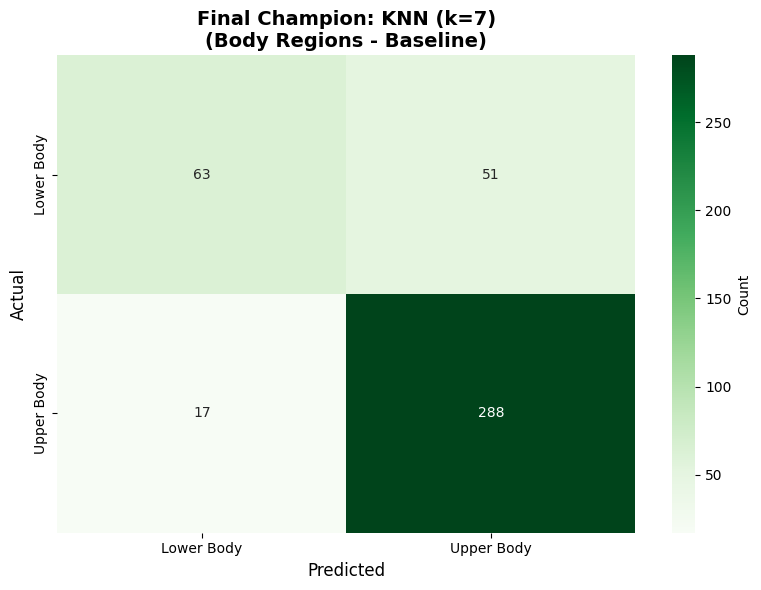

In [139]:
# Evaluation of final champion
# Determine which champion to use based on best F1
if final_champion_row['Approach'] == 'Body Regions':
    if final_champion_row['Iteration'] == 'Tuned':
        final_model = best_models_region[tuning_df_region.iloc[0]['Model'].replace(' (Tuned)', '')]
        X_test_final = X_test_region_scaled
        y_test_final = y_test_region
    else:  # Baseline
        final_model = trained_region[champion_region_baseline]
        X_test_final = X_test_region_scaled
        y_test_final = y_test_region
    
    classes = sorted(y_region.unique())
else:  # 14-class
    if final_champion_row['Iteration'] == 'Tuned':
        final_model = best_models_14class[tuning_df_14class.iloc[0]['Model'].replace(' (Tuned)', '')]
    else:
        final_model = trained_14class[champion_14class_baseline]
    X_test_final = X_test_scaled
    y_test_final = y_test
    classes = sorted(y.unique())

# Get predictions
y_pred_final = final_model.predict(X_test_final)

# Classification report
print("=== FINAL CHAMPION - Classification Report ===\n")
print(classification_report(y_test_final, y_pred_final, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred_final, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'})
plt.title(f'Final Champion: {final_champion_row["Model"]}\n({final_champion_row["Approach"]} - {final_champion_row["Iteration"]})', 
          fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [142]:
# Save the final champion model with complete artifact for deployment
import os
os.makedirs('models', exist_ok=True)

# Compute test metrics
test_f1 = f1_score(y_test_final, y_pred_final, average='weighted', zero_division=0)
test_acc = accuracy_score(y_test_final, y_pred_final)

# Create complete model artifact with all required fields for app.py
model_dictionary = {
    'model': final_model,
    'feature_columns': features_region,
    'classes': sorted(y_region.unique()),
    'test_metrics': {
        'f1_weighted': test_f1,
        'accuracy': test_acc
    }
}

model_filename = 'models/final_champion_model_A3.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_dictionary, f)

print(f'Champion model saved: {model_filename}')
print(f'Keys in artifact: {list(model_dictionary.keys())}')
print(f'Number of features: {len(features_region)}')
print(f"Classes: {model_dictionary['classes']}")
print(f'Test F1: {test_f1:.4f}, Accuracy: {test_acc:.4f}')

Champion model saved: models/final_champion_model_A3.pkl
Keys in artifact: ['model', 'feature_columns', 'classes', 'test_metrics']
Number of features: 41
Classes: ['Lower Body', 'Upper Body']
Test F1: 0.8278, Accuracy: 0.8377


## 10. Deployment

The classification endpoint is added to the existing Gradio app as a second tab. Tab 1 has Movement Scoring from A2. Tab 2 has Body Region Classification which takes 38 deviation features as input and outputs the predicted body region (Upper Body or Lower Body). The deployed model is KNN (k=7) with StandardScaler preprocessing, achieving 82.8% F1-score.

Deployment URL: https://huggingface.co/spaces/Bachstelze/github_sync

## 11. Virtual environment

```bash
python -m venv venv
source venv/bin/activate
pip install -r requirements.txt
```

## 12. DevOps/MLOps process

GitHub Actions automatically syncs the repository to HuggingFace Spaces when pushed to main. The workflow file is found at .github/workflows/push_to_hf_space.yml.

## 13. Contributions 

| Member | GitHub Issue | Tasks |
|--------|--------------|-------|
| Reem | #8 Data Preparation | Merge datasets, create WeakestLink column |
| Rasa | #9 Classification Models | Train/evaluate classifiers (A3_Test.ipynb) |
| Amol | #10 Deployment | Add classification endpoint to Gradio, final report |
| Kalle | #11 Dependency Management | requirements.txt, CI checks |

## 14. Iterations

| # | Iteration | Approach | Key change |
|---|-----------|----------|------------|
| 1 | Baseline | 14-Class | Default hyperparameters |
| 2 | Tuned | 14-Class | GridSearchCV (5-fold CV) |
| 3 | Baseline | Body Regions | Grouped classes (Upper/Lower) |
| 4 | Tuned | Body Regions | GridSearchCV (5-fold CV) |

Note: Polynomial interaction features were tested but not included in final iterations due to minimal improvement and increased complexity (820 features vs 38).

### Deployed Model

The deployed model uses body region classification with KNN (k=7) and StandardScaler preprocessing. It takes 38 input features and achieves 82.8% F1-weighted and 84% accuracy on the test set.